In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

In [2]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('B')
ts = ts.interpolate(method='linear')
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


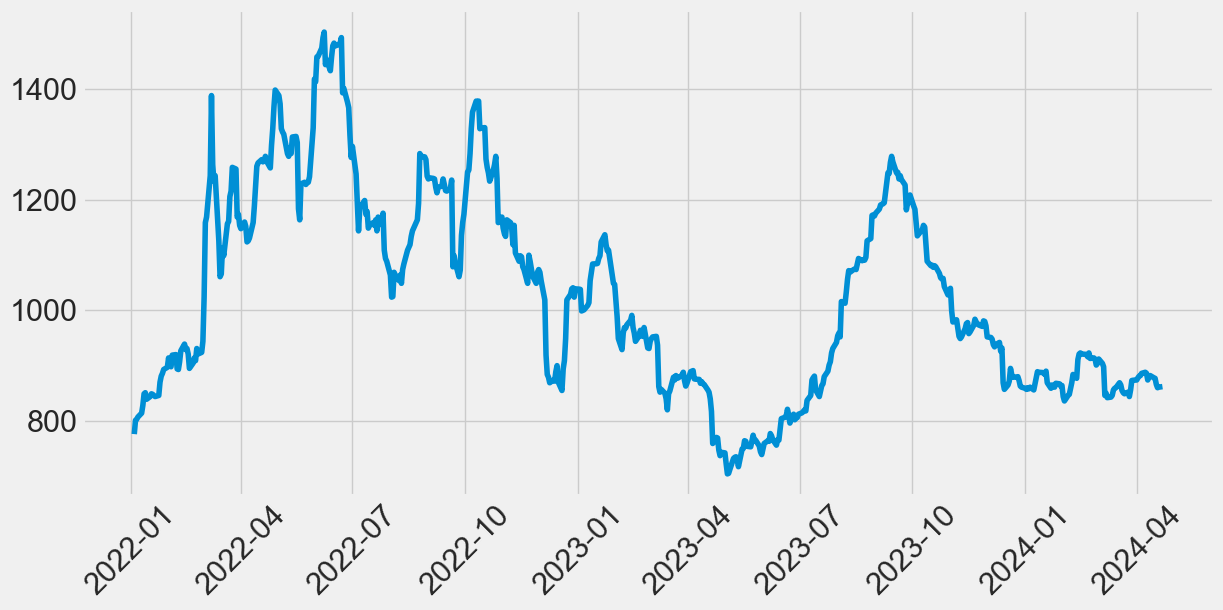

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(ts);

In [4]:
last_date = ts.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

((590, 1), (10, 1))

In [5]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [6]:
def add_business_day_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = df[col_name].shift(days)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

lag_days_list = [10, 20, 60, 120]

train_val = add_business_day_lags(train_val, 'Marine Gasoil 9_Price', lag_days_list)
test = add_business_day_lags(test, 'Marine Gasoil 9_Price', lag_days_list)

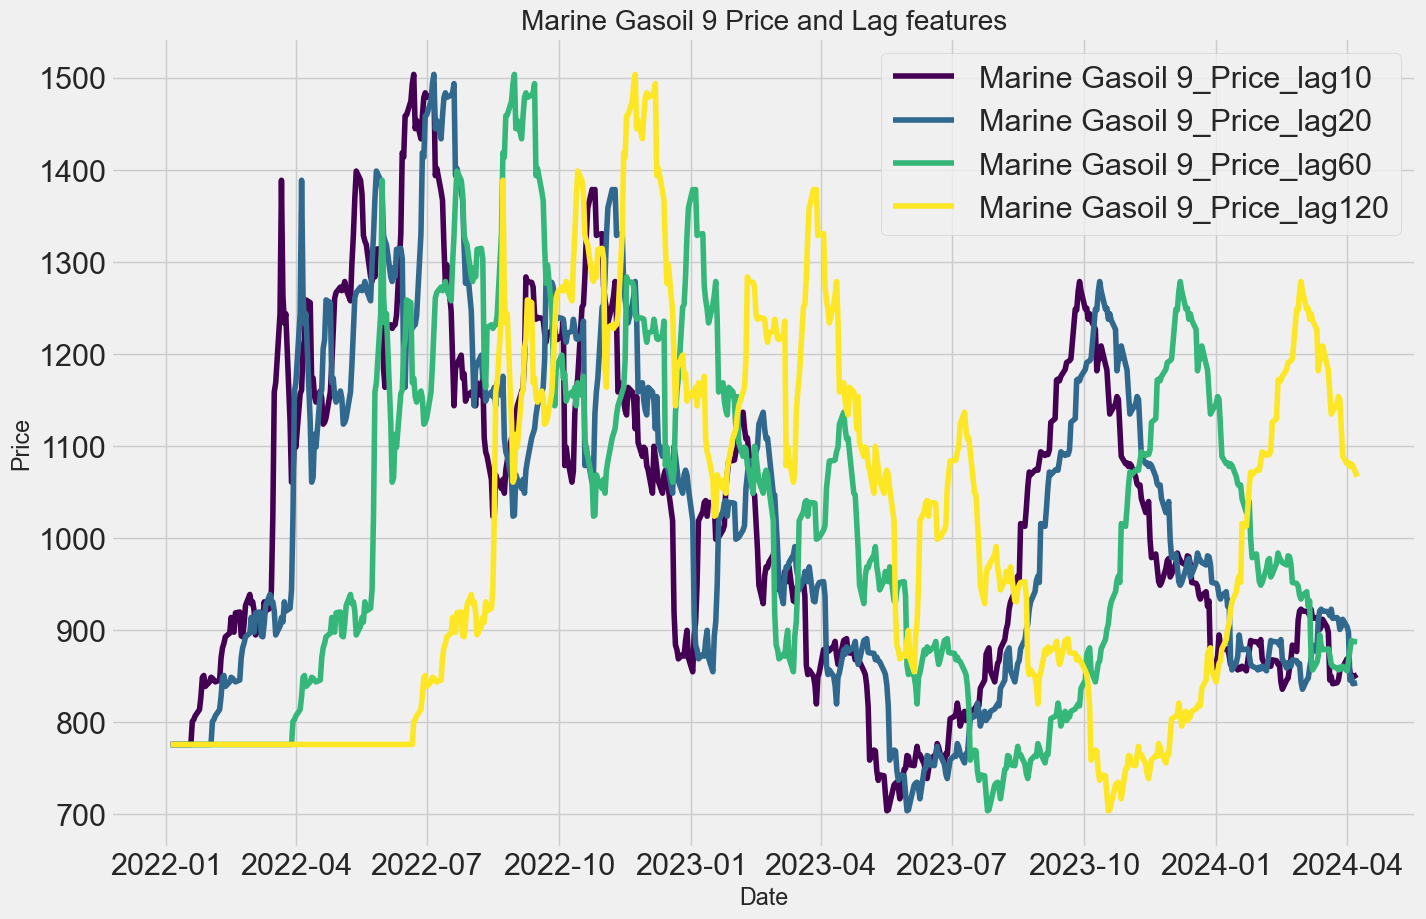

In [7]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120'
    ]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Lag features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

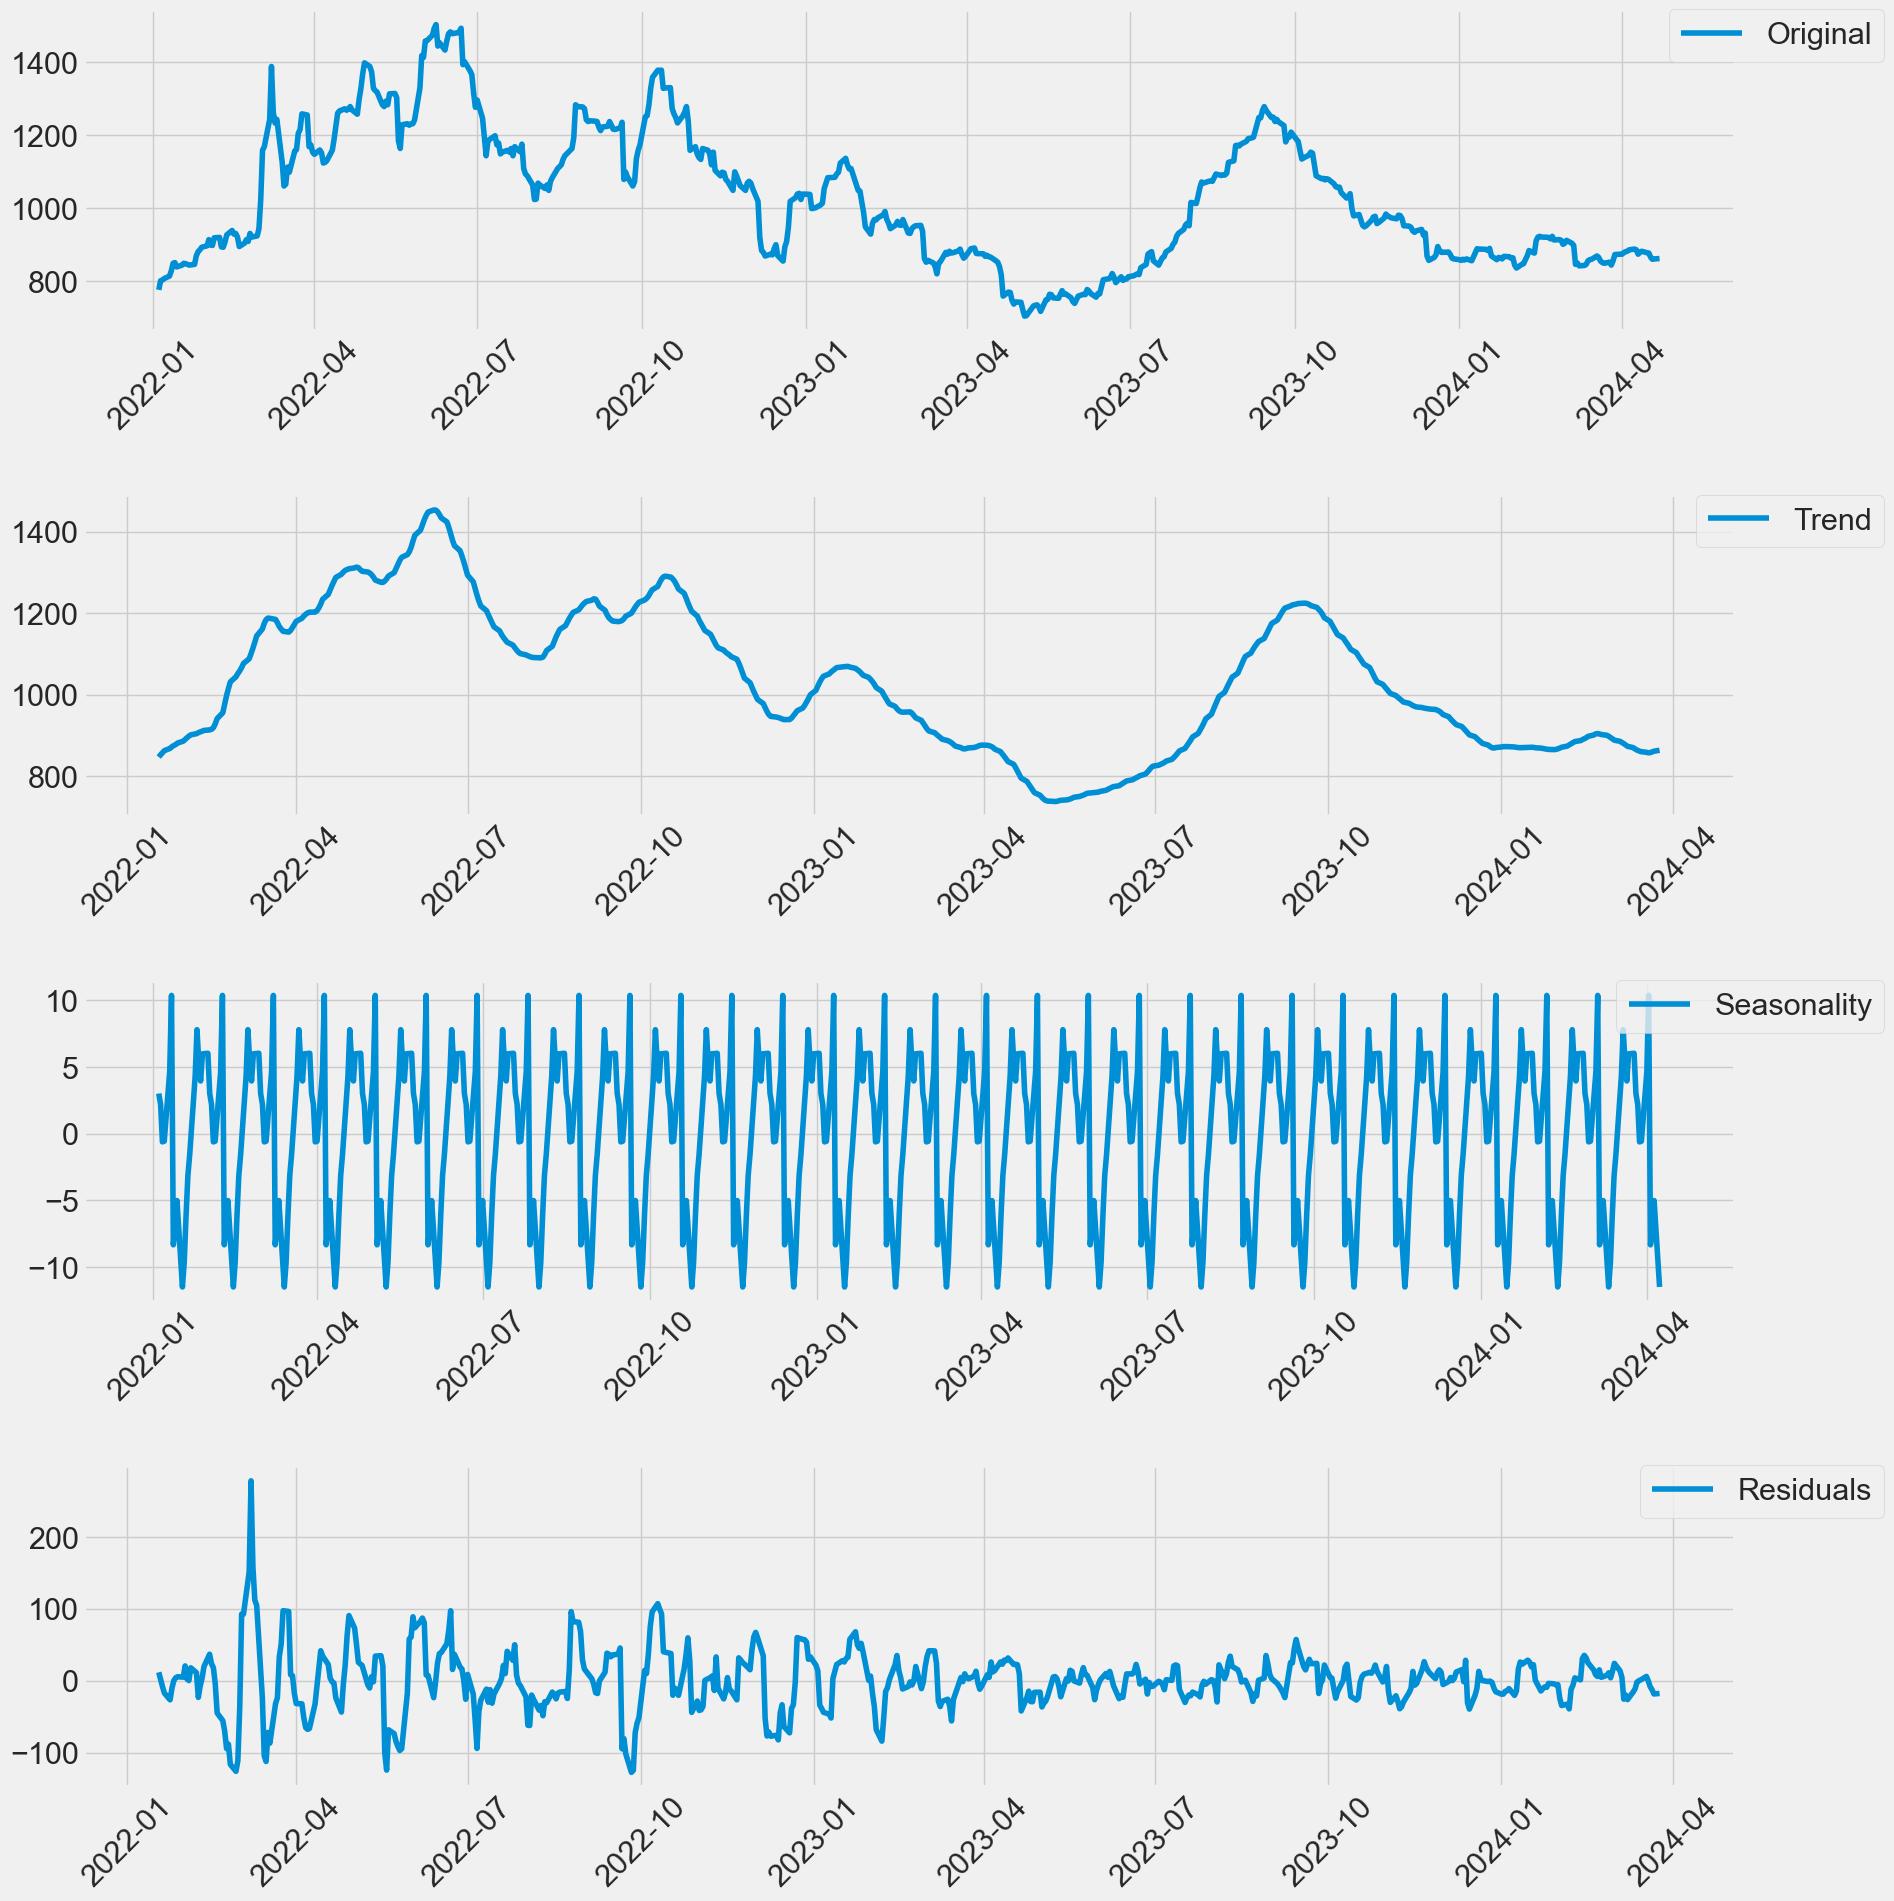

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_val['Marine Gasoil 9_Price'], period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

plt.rcParams["figure.figsize"] = (20, 20)
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout(pad=3.0)
plt.show()

In [9]:
train_val['trend'] = trend
train_val['seasonal'] = seasonal
train_val.head(30)

,Marine Gasoil 9_Price,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,trend,seasonal
Date,,,,,,,,,,,,,,
2022-01-04,775.5,2022,1,1,1,4,1,4,775.5,775.5,775.5,775.5,NaN,3.007006
2022-01-05,800.5,2022,1,1,2,5,1,5,775.5,775.5,775.5,775.5,NaN,2.181114
2022-01-06,802.5,2022,1,1,3,6,1,6,775.5,775.5,775.5,775.5,NaN,-0.623351
2022-01-07,806.5,2022,1,1,4,7,1,7,775.5,775.5,775.5,775.5,NaN,-0.577815
2022-01-10,813.5,2022,1,1,0,10,2,10,775.5,775.5,775.5,775.5,NaN,4.637364
2022-01-11,827.5,2022,1,1,1,11,2,11,775.5,775.5,775.5,775.5,NaN,10.371292
2022-01-12,848.5,2022,1,1,2,12,2,12,775.5,775.5,775.5,775.5,NaN,-8.351029
2022-01-13,850.5,2022,1,1,3,13,2,13,775.5,775.5,775.5,775.5,NaN,-7.010851
2022-01-14,838.5,2022,1,1,4,14,2,14,775.5,775.5,775.5,775.5,NaN,-5.029601


In [10]:
train_val.tail(10)

,Marine Gasoil 9_Price,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,trend,seasonal
Date,,,,,,,,,,,,,,
2024-03-26,843.5,2024,1,3,1,26,13,86,845.5,911.5,856.5,1153.5,NaN,3.007006
2024-03-27,855.5,2024,1,3,2,27,13,87,855.5,900.5,859.5,1150.5,NaN,2.181114
2024-03-28,872.5,2024,1,3,3,28,13,88,858.5,903.5,857.5,1118.5,NaN,-0.623351
2024-03-29,873.0,2024,1,3,4,29,13,89,859.5,911.5,860.5,1088.5,NaN,-0.577815
2024-04-01,873.5,2024,2,4,0,1,14,92,868.5,903.5,855.5,1080.5,NaN,4.637364
2024-04-02,877.5,2024,2,4,1,2,14,93,864.5,897.5,866.5,1081.5,NaN,10.371292
2024-04-03,880.5,2024,2,4,2,3,14,94,854.5,845.5,877.5,1077.5,NaN,-8.351029
2024-04-04,881.5,2024,2,4,3,4,14,95,850.5,849.5,888.5,1080.5,NaN,-7.010851
2024-04-05,885.5,2024,2,4,4,5,14,96,848.5,841.5,887.5,1078.5,NaN,-5.029601


## Experiment 1. Sliding window

In [ ]:
# def apply_sliding_window(train_feature, test_index, window_size):
#     extended_feature = []
#     windows = []
    
#     for test_date in test_index:
#         start_date = test_date - pd.Timedelta(days=window_size)
#         window_values = train_feature.loc[start_date:test_date]
#         if not window_values.empty:
#             extended_feature.append(window_values.mean())
#             windows.append(window_values)
#         else:
#             extended_feature.append(np.nan)
#             windows.append(pd.Series())
    
#     return extended_feature, windows

# # Test 데이터의 날짜 리스트
# test_dates = test.index

# # Window size 설정
# window_size = 14

# # Test 데이터에 대해 Trend와 Seasonal feature 적용
# trend_features, trend_windows = apply_sliding_window(train_val['trend'], test_dates, window_size)
# seasonal_features, seasonal_windows = apply_sliding_window(train_val['seasonal'], test_dates, window_size)

# test['trend'] = trend_features
# test['seasonal'] = seasonal_features

## Experiment 2. Sliding window (recursive)

In [37]:
# def apply_sliding_window(train_feature, test_index, window_size):
#     extended_feature = []
#     windows = []
    
#     full_data = train_feature.copy()  # 훈련 데이터를 복사하여 사용
    
#     for test_date in test_index:
#         start_date = test_date - pd.Timedelta(days=window_size - 1)
#         window_values = full_data.loc[start_date:test_date]
#         if not window_values.empty:
#             mean_value = window_values.mean()
#             extended_feature.append(mean_value)
#             windows.append(window_values)
#             # 테스트 데이터를 훈련 데이터에 추가하여 재귀적으로 사용
#             full_data[test_date] = mean_value
#         else:
#             extended_feature.append(np.nan)
#             windows.append(pd.Series())
    
#     return extended_feature, windows

# # Test 데이터의 날짜 리스트
# test_dates = test.index

# # Window size 설정
# window_size = 14

# # Test 데이터에 대해 Trend와 Seasonal feature 적용
# trend_features, trend_windows = apply_sliding_window(train_val['trend'], test_dates, window_size)
# seasonal_features, seasonal_windows = apply_sliding_window(train_val['seasonal'], test_dates, window_size)

# test['trend'] = trend_features
# test['seasonal'] = seasonal_features

In [38]:
test

,Marine Gasoil 9_Price,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,trend,seasonal
Date,,,,,,,,,,,,,,
2024-04-09,885.5,2024,2,4,1,9,15,100,NaN,NaN,NaN,NaN,NaN,-1.768721
2024-04-10,873.5,2024,2,4,2,10,15,101,NaN,NaN,NaN,NaN,NaN,-2.207592
2024-04-11,878.5,2024,2,4,3,11,15,102,NaN,NaN,NaN,NaN,NaN,-2.383618
2024-04-12,881.5,2024,2,4,4,12,15,103,NaN,NaN,NaN,NaN,NaN,-2.584263
2024-04-15,877.5,2024,2,4,0,15,16,106,NaN,NaN,NaN,NaN,NaN,-3.386666
2024-04-16,876.5,2024,2,4,1,16,16,107,NaN,NaN,NaN,NaN,NaN,-4.915328
2024-04-17,865.5,2024,2,4,2,17,16,108,NaN,NaN,NaN,NaN,NaN,-4.533584
2024-04-18,859.5,2024,2,4,3,18,16,109,NaN,NaN,NaN,NaN,NaN,-4.258332
2024-04-19,860.5,2024,2,4,4,19,16,110,NaN,NaN,NaN,NaN,NaN,-4.172635


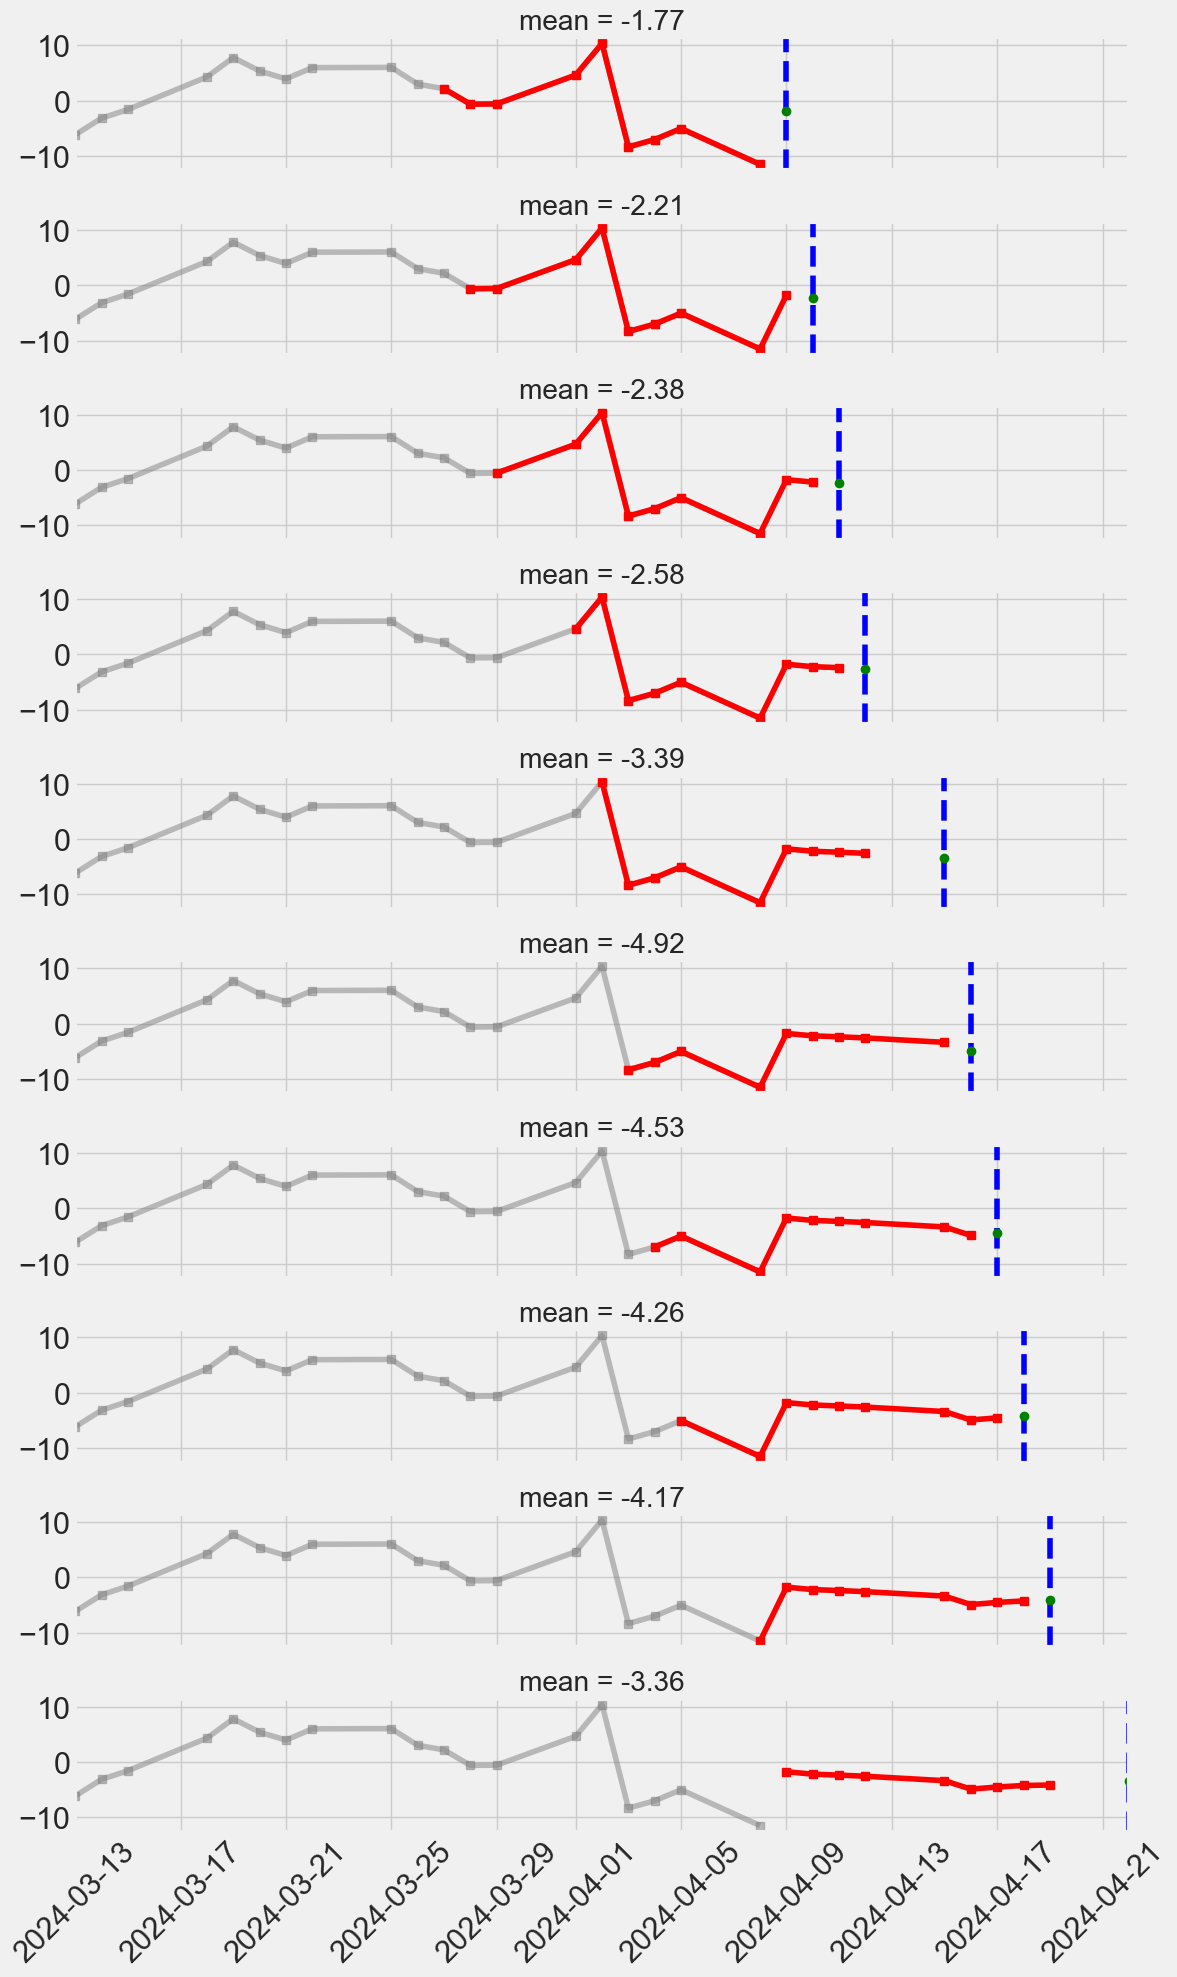

In [39]:
# # 슬라이딩 윈도우 적용 및 결과 시각화
# fig, axes = plt.subplots(len(test_dates), 1, figsize=(12, 20), sharex=True)

# for i, (test_date, window) in enumerate(zip(test_dates, seasonal_windows)):
#     axes[i].plot(train_val.index, train_val['seasonal'], 's-', color='grey', alpha=0.5, label='Seasonal Data')
#     if not window.empty:
#         axes[i].plot(window.index, window.values, 's-', color='red', label='Window Data')
#         axes[i].axvline(test_date, color='blue', linestyle='--', label='Test Date')
#         axes[i].set_xlim([test_date - pd.Timedelta(days=40), test_date])
#         axes[i].set_title(f'mean = {window.mean():.2f}')

# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Experiment 3. 주기 반복

In [71]:
# 주기적 반복 함수 정의
def apply_periodic_seasonal(train_feature, test_index, period):
    extended_feature = []
    train_length = len(train_feature)
    start_point = train_length - period
    for i, test_date in enumerate(test_index):
        index_in_period = (start_point + i) % train_length
        extended_feature.append(train_feature.iloc[index_in_period])
    return extended_feature

# 주기 설정
period = 20

# Test 데이터에 대해 Seasonal feature 적용
seasonal_features = apply_periodic_seasonal(train_val['seasonal'], test_dates, period)
test['seasonal'] = seasonal_features

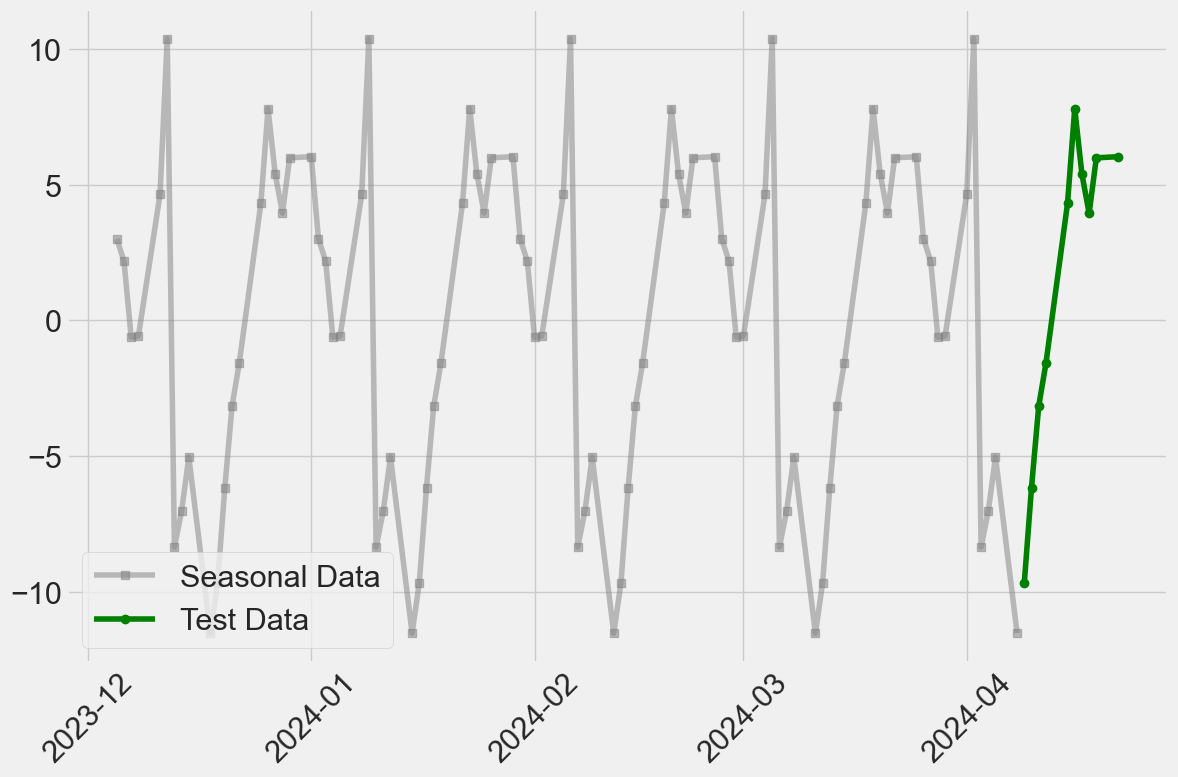

In [72]:
# 최근 90일 데이터 선택
recent_90_days = train_val.index[-90:]

# 결과 시각화
fig, ax = plt.subplots(figsize=(12, 8))

# 전체 train_val 데이터 시각화 (최근 90일 기준)
ax.plot(train_val.loc[recent_90_days].index, train_val.loc[recent_90_days]['seasonal'], 's-', color='grey', alpha=0.5, label='Seasonal Data')

# 테스트 데이터의 선 시각화
ax.plot(test.index, test['seasonal'], 'o-', color='green', label='Test Data')

# 중복 범례 제거
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((570, 14), (20, 14), (10, 14))

In [15]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [16]:
# 모델 정의
xgb_model = XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=10000, early_stopping_rounds=50,
    objective='reg:squarederror', max_depth=6,
    learning_rate=0.01, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0, reg_lambda=1,
    random_state=42
)

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1229.61213
[100]	validation_0-rmse:477.46848
[200]	validation_0-rmse:213.89678
[300]	validation_0-rmse:149.45387
[400]	validation_0-rmse:129.38928
[500]	validation_0-rmse:124.39817
[600]	validation_0-rmse:122.52055
[700]	validation_0-rmse:121.37395
[800]	validation_0-rmse:120.78561
[900]	validation_0-rmse:120.37617
[1000]	validation_0-rmse:120.23834
[1100]	validation_0-rmse:120.12278
[1200]	validation_0-rmse:120.07402
[1300]	validation_0-rmse:120.04770
[1400]	validation_0-rmse:120.01215
[1500]	validation_0-rmse:120.00164
[1529]	validation_0-rmse:120.00015
[0]	validation_0-rmse:1067.12647
[100]	validation_0-rmse:414.24774
[200]	validation_0-rmse:203.10913
[300]	validation_0-rmse:142.78990
[400]	validation_0-rmse:126.92991
[500]	validation_0-rmse:123.52684
[600]	validation_0-rmse:122.99467
[700]	validation_0-rmse:122.91543
[713]	validation_0-rmse:122.95924
[0]	validation_0-rmse:810.16267
[100]	validation_0-rmse:219.39497
[200]	validation_0-rmse:66.62100
[255]	valida

In [18]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [93.8094146105708, 94.25290747402477, 53.13255092075893, 41.305283526985015, 21.766630211654974]
Average MAE across folds: 60.85
RMSE for each fold: [119.99971048563805, 122.80961921519568, 66.43334065748522, 48.120072065323214, 26.59059211971261]
Average RMSE across folds: 76.79
MAPE for each fold: [7.487714354344945, 9.221562021453625, 6.503169533370482, 3.8850404484567043, 2.4444779060312642]
Average MAPE across folds: 5.91


In [19]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:877.90786
[100]	validation_0-rmse:322.90357
[200]	validation_0-rmse:122.22717
[300]	validation_0-rmse:55.15431
[400]	validation_0-rmse:34.84156
[500]	validation_0-rmse:29.00374
[600]	validation_0-rmse:27.27901
[700]	validation_0-rmse:26.69167
[800]	validation_0-rmse:26.62765
[824]	validation_0-rmse:26.60147


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_xgb_val_cv,prediction_xgb_cv
Date,,,
2022-01-04,775.5,NaN,NaN
2022-01-05,800.5,NaN,NaN
2022-01-06,802.5,NaN,NaN
2022-01-07,806.5,NaN,NaN
2022-01-10,813.5,NaN,NaN
...,...,...,...
2024-04-16,876.5,NaN,893.078918
2024-04-17,865.5,NaN,890.687744
2024-04-18,859.5,NaN,890.144226


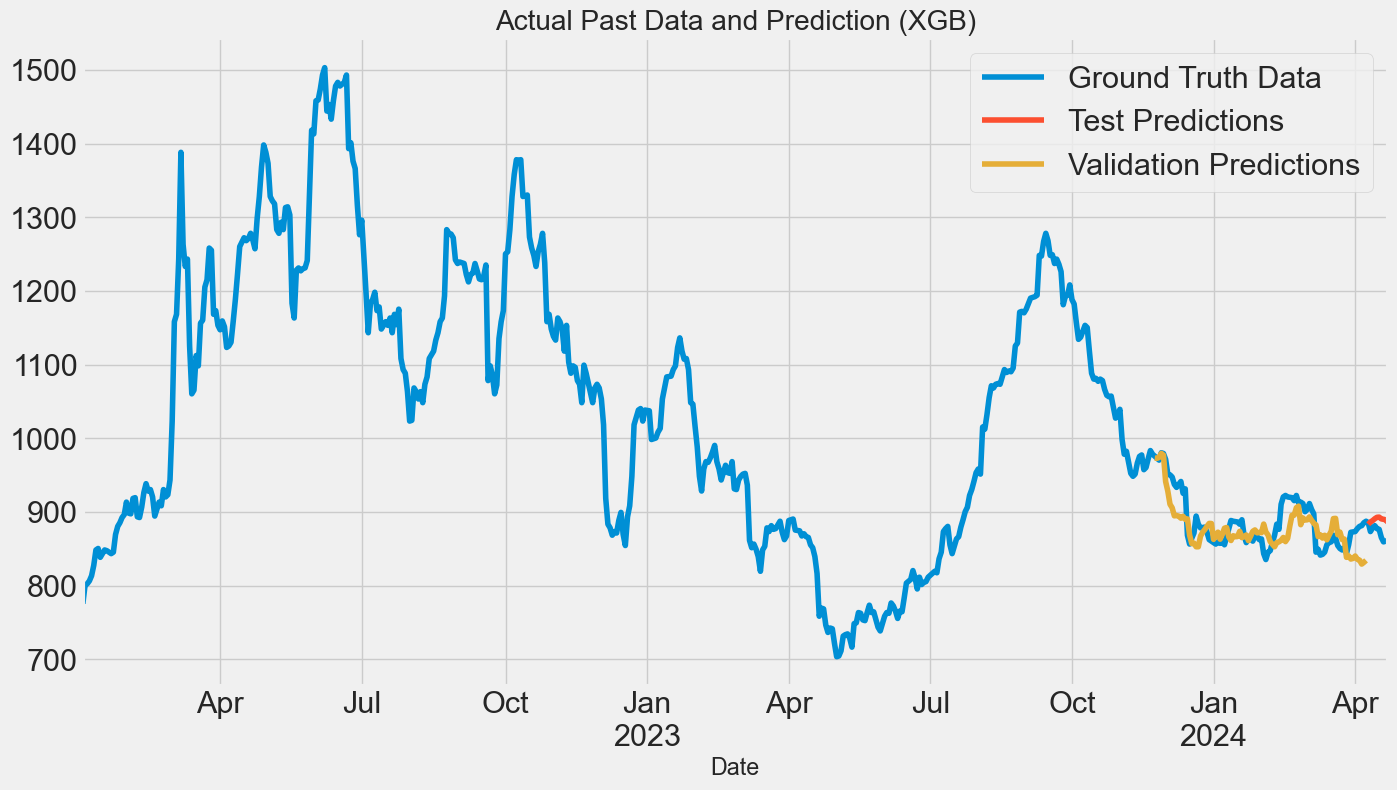

In [21]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_cv'].plot(ax=ax, style='-')
ts['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

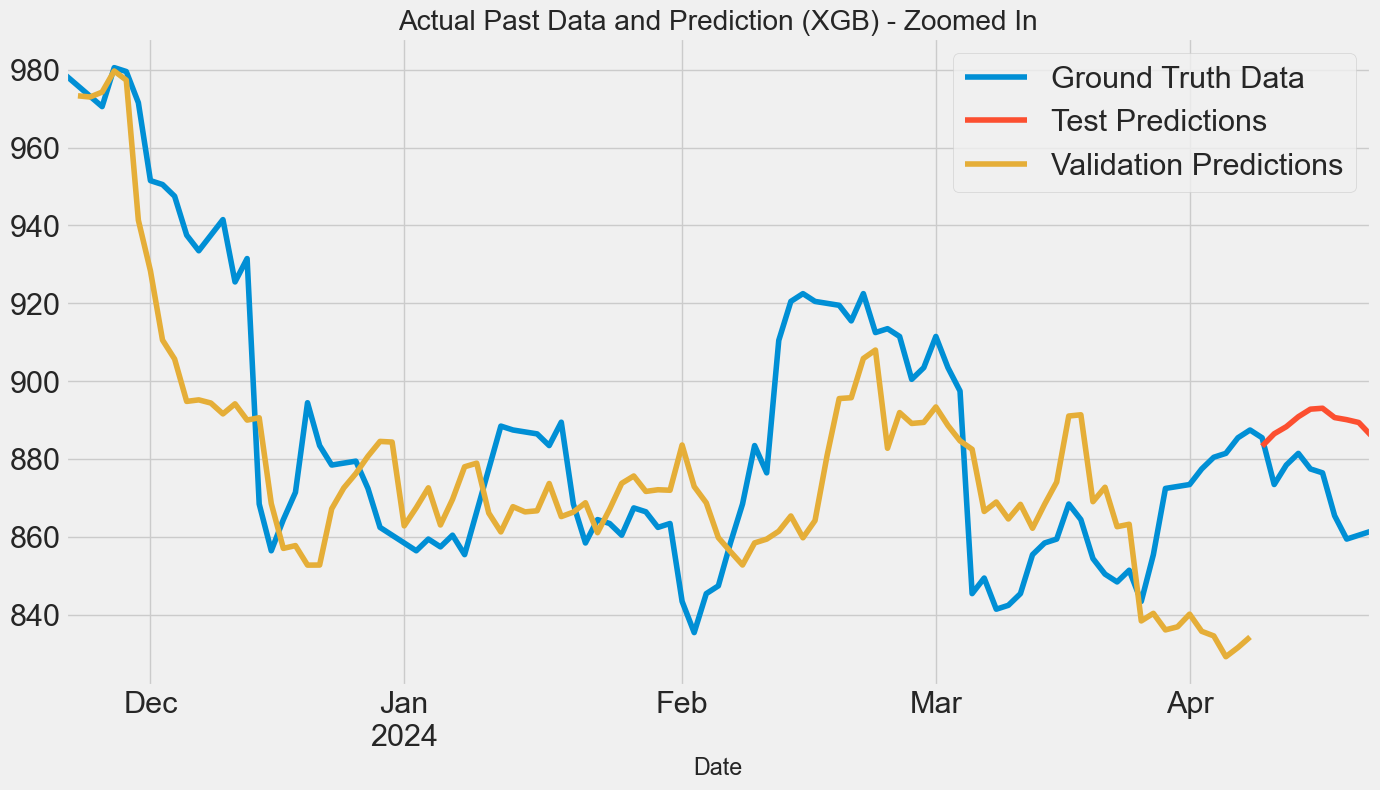

In [22]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-11-22'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 21.77
RMSE Score on Validation set (XGB): 26.59
MAPE Score on Validation set (XGB): 2.44%


In [24]:
ts_clean = ts.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Test set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Test set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Test set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (XGB): 17.58
RMSE Score on Test set (XGB): 19.72
MAPE Score on Test set (XGB): 2.03%


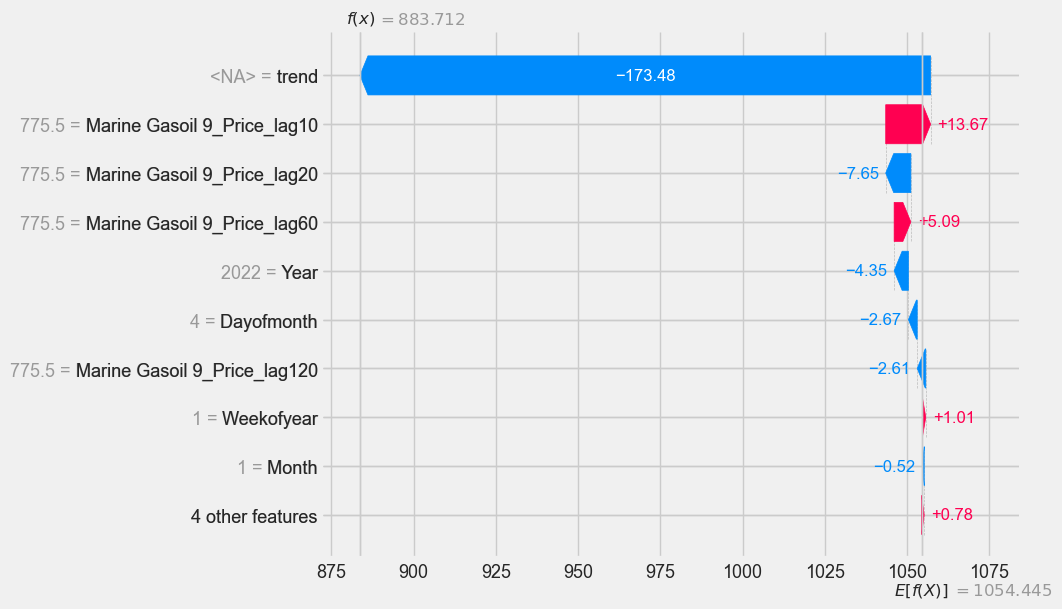

In [25]:
import shap

xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))